# **UNET (transfer learning) + LSTM Stateful de WT2. One-Future step 24hras (1 etiqueta futura). Fase de prueba: foward walk validation**

Este script aplica un modelo UNET + LSTM sobre las imágenes 8x8x3 del dataset imagenes_8x8_WT2.csv.

La idea en este punto del TFG es continuar con modelos mas complejos que puedan capturar dependencias temporales mas a largo plazo y que no sea mediante un comportamiento aleatorio.

Se concluye que la mejor via para hacerlo es mediante UNET + LSTM stateful.

En los dos primeros modelos se analiza un sobreajuste sobre la serie temporal de 2016. Para solucionarlo, se prueba a entrenar el modelo con 1 o 2 epochs.

El analisis de los resultados de los diferentes entrenos con las epochs se puede incluir en el TFG como continuacion del estudio baseline.

El siguiente paso a este script es hacer lo mismo pero entrenando un modelo UNET + LSTM Stateful regresivo multio-utput que prediga varios valores futuros de la serie temporal.

## **Importación de módulos y librerías**

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from numpy import array
from numpy import newaxis

#Data Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

#Neuronal Network API
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import l2
from keras.models import load_model

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import os
import collections

In [2]:
%matplotlib inline
print(plt.style.available)
plt.style.use('seaborn-v0_8')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Lectura**

In [4]:
df_columns = pd.read_csv('/content/drive/MyDrive/unet+lstm_regresion_one_step/imagenes_8x8_WT2.csv', nrows=1)

In [5]:
variables = ['Amb_WindSpeed_Avg', 'Grd_Prod_Pwr_Avg', 'Blds_PitchAngle'] #,'Rtr_RPM_Avg']
variables_id = ['Id', 'Fecha_Inicio', 'Fecha_Fin', 'label']

columns_read = [col for col in df_columns.columns if any([v in col for v in variables + variables_id])]
df_wt2_completo = pd.read_csv('/content/drive/MyDrive/unet+lstm_regresion_one_step/imagenes_8x8_WT2.csv', usecols=columns_read)

In [6]:
print(collections.Counter(df_wt2_completo['label']))

Counter({0: 39202, 1: 2934, -1: 818, 5: 424, 2: 227, 3: 135})


In [7]:
df_wt2_completo['label'] = df_wt2_completo['label']+1
df_wt2_completo.loc[(df_wt2_completo['label']==6),'label'] = 5

In [8]:
valores_distintos = df_wt2_completo['label'].value_counts()

# Imprimir el resultado
print("Número de valores distintos en la columna 'etiqueta_rendimiento':")
print(valores_distintos)

Número de valores distintos en la columna 'etiqueta_rendimiento':
label
1    39202
2     2934
0      818
5      424
3      227
4      135
Name: count, dtype: int64


In [9]:
df_wt2_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43740 entries, 0 to 43739
Columns: 196 entries, Id to Blds_PitchAngle_Avg_64
dtypes: float64(192), int64(2), object(2)
memory usage: 65.4+ MB


In [10]:
df_wt2_completo.head(1)

,Id,Fecha_Inicio,Fecha_Fin,label,Amb_WindSpeed_Avg_1,Amb_WindSpeed_Avg_2,Amb_WindSpeed_Avg_3,Amb_WindSpeed_Avg_4,Amb_WindSpeed_Avg_5,Amb_WindSpeed_Avg_6,...,Blds_PitchAngle_Avg_55,Blds_PitchAngle_Avg_56,Blds_PitchAngle_Avg_57,Blds_PitchAngle_Avg_58,Blds_PitchAngle_Avg_59,Blds_PitchAngle_Avg_60,Blds_PitchAngle_Avg_61,Blds_PitchAngle_Avg_62,Blds_PitchAngle_Avg_63,Blds_PitchAngle_Avg_64
0,2,2009-06-28 12:30:00,2009-06-28 23:10:00,5,4.7,4.6,5.3,5.5,3.8,5.8,...,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0


In [11]:
df_wt2_completo.tail(1)

,Id,Fecha_Inicio,Fecha_Fin,label,Amb_WindSpeed_Avg_1,Amb_WindSpeed_Avg_2,Amb_WindSpeed_Avg_3,Amb_WindSpeed_Avg_4,Amb_WindSpeed_Avg_5,Amb_WindSpeed_Avg_6,...,Blds_PitchAngle_Avg_55,Blds_PitchAngle_Avg_56,Blds_PitchAngle_Avg_57,Blds_PitchAngle_Avg_58,Blds_PitchAngle_Avg_59,Blds_PitchAngle_Avg_60,Blds_PitchAngle_Avg_61,Blds_PitchAngle_Avg_62,Blds_PitchAngle_Avg_63,Blds_PitchAngle_Avg_64
43739,2,2017-03-09 21:40:00,2017-03-10 08:20:00,1,7.3,7.3,6.9,6.8,6.4,5.9,...,-1.0,-1.1,-1.1,-0.7,-0.1,0.1,0.0,-0.2,-0.6,-0.9


In [12]:
# Número de etiquetas por año
años = pd.DataFrame()

años['Fecha_Inicio'] = pd.to_datetime(df_wt2_completo['Fecha_Inicio'])
años['Fecha_Fin'] = pd.to_datetime(df_wt2_completo['Fecha_Fin'])

# Extraemos el año de la columna 'inicio' y contamos las ocurrencias
conteo_por_año = años['Fecha_Inicio'].dt.year.value_counts().sort_index()

print(conteo_por_año)

Fecha_Inicio
2009    2785
2010    5688
2011    5702
2012    5717
2013    5714
2014    5688
2015    5663
2016    5709
2017    1074
Name: count, dtype: int64


## **Division en training, test,**
- El conjunto de entrenamiento recoge imagenes de 2009 - 2015
- El conjunto de prueba: 2016

In [13]:
df_wt2_completo_copy = df_wt2_completo.copy()

In [14]:
df_wt2_completo_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43740 entries, 0 to 43739
Columns: 196 entries, Id to Blds_PitchAngle_Avg_64
dtypes: float64(192), int64(2), object(2)
memory usage: 65.4+ MB


In [15]:
# Convertimos las columnas de fecha en objetos datetime
df_wt2_completo_copy['Fecha_Inicio'] = pd.to_datetime(df_wt2_completo_copy['Fecha_Inicio'])
df_wt2_completo_copy['Fecha_Fin'] = pd.to_datetime(df_wt2_completo_copy['Fecha_Fin'])

# Filtramos las filas del año 2016
df_testing_2016 = df_wt2_completo_copy[df_wt2_completo_copy['Fecha_Inicio'].dt.year == 2016]

# Filtramos las filas excepto las del año 2016 ni las de 2017
df_training = df_wt2_completo_copy[(df_wt2_completo_copy['Fecha_Inicio'].dt.year != 2016) & (df_wt2_completo_copy['Fecha_Inicio'].dt.year != 2017)]

In [16]:
# Obtenemos las etiquetas destino
performance_training = df_training["label"].to_numpy()
performance_testing = df_testing_2016["label"].to_numpy()

In [17]:
print("Numero de etiquetas de entrenamiento: " + str(len(df_training)))
print("Numero de etiquetas de prueba: " + str(len(df_testing_2016)))

Numero de etiquetas de entrenamiento: 36957
Numero de etiquetas de prueba: 5709


In [18]:
columnas_filtradas = [col for col in df_wt2_completo.columns if any(v in col for v in variables)]

dataset_training = df_training[columnas_filtradas].to_numpy()
dataset_testing = df_testing_2016[columnas_filtradas].to_numpy()

In [19]:
dataset_training = np.swapaxes(dataset_training.reshape(-1,3,8,8),1,3)
dataset_testing = np.swapaxes(dataset_testing.reshape(-1,3,8,8),1,3)

In [20]:
print(dataset_training.shape)
print(dataset_testing.shape)

(36957, 8, 8, 3)
(5709, 8, 8, 3)


In [21]:
dataset_training =  tf.image.resize_with_pad(dataset_training, 16, 16, method='bicubic')
dataset_training = dataset_training.numpy().astype('float32')
print(dataset_training.shape)

dataset_testing =  tf.image.resize_with_pad(dataset_testing, 16, 16, method='bicubic')
dataset_testing = dataset_testing.numpy().astype('float32')
print(dataset_testing.shape)

(36957, 16, 16, 3)
(5709, 16, 16, 3)


In [22]:
# split a univariate sequence into samples. Targets isnt normalized
def split_sequence(sequence, targets, n_steps_in, n_steps_out, future_steps, stride = None):
  if stride is  None:
    stride = 1
  X, y = list(), list()
  for i in range(0, len(sequence), stride):
    # find the end of this pattern
    end_ix = i + n_steps_in

    out_start_ix = end_ix + future_steps
    out_end_ix = out_start_ix + n_steps_out

    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], targets[out_start_ix:out_end_ix]
    X.append(seq_x)
    if n_steps_out == 1:
      y.append(seq_y[0])  # Si solo hay un paso de salida, añadir solo el valor
    else:
      y.append(seq_y)
  return array(X), array(y)

### **Preparacion training set**

In [23]:
sequence_length = 65
output_steps = 1
batch_size = 1
future_steps = 5

In [24]:
X_train, y_train = split_sequence(dataset_training, performance_training, sequence_length, output_steps, future_steps, stride = sequence_length)

In [25]:
print(X_train.shape)
print(y_train.shape)

(568, 65, 16, 16, 3)
(568,)


In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size)

In [27]:
print(f"Número de batches train = secuencias: {sum(1 for _ in train_dataset)}")

Número de batches train = secuencias: 568


In [28]:
i = 0
for samples, targets in train_dataset:
        print("it: ", i)
        print("samples shape:", samples.shape)
        print("targets shape:", targets.shape)
        print(targets.dtype)
        i = i + 1
        break

it:  0
samples shape: (1, 65, 16, 16, 3)
targets shape: (1,)
<dtype: 'int64'>


In [29]:
def visualization (history):

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='best')
  plt.show()

  # summarize history for MAE
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.title('Model MAE')
  plt.ylabel('MAE')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='best')
  plt.show()

### **Preparacion testing set**

In [30]:
sequence_length = 65
output_steps = 1
batch_size = 1

In [31]:
X_test, y_test = split_sequence(dataset_testing, performance_testing, sequence_length, output_steps, future_steps, stride = sequence_length)

In [32]:
print(X_test.shape)
print(y_test.shape)

(87, 65, 16, 16, 3)
(87,)


In [33]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

In [34]:
print(f"Número de batches test = secuencias: {sum(1 for _ in test_dataset)}")

Número de batches test = secuencias: 87


In [35]:
i = 0
for samples, targets in test_dataset:
        print("it: ", i)
        print("samples shape:", samples.shape)
        print("targets shape:", targets.shape)
        print(targets.dtype)
        i = i + 1
        break

it:  0
samples shape: (1, 65, 16, 16, 3)
targets shape: (1,)
<dtype: 'int64'>


In [36]:
def visualization (history):

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='best')
  plt.show()

  # summarize history for MAE
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.title('Model MAE')
  plt.ylabel('MAE')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='best')
  plt.show()

## Funcion de prediccion

In [37]:
### dataset: es la serie temporal de etiquetas
### output_steps: es el numero de steps futuros predichos por el modelo dada una Secuencia
### window_size es la longitud de cada secuencia
### n_sequences: indica el numero de secuencias a predecir. None para predecir todas las del dataset
### n_epochs: número de epochs el entrenamiento
def prediccion_secuencias_multiples(model, dataset, output_steps, window_size, n_sequences, n_epochs):

  prediction_seqs = []
  curr_frame = []
  stop_point = len(dataset) - window_size

  contador = 0

  # Iterar sobre el conjunto de datos con un paso de la longitud de secuencia
  for sequence, target in dataset:
      contador = contador + 1

      # Preparo la secuencia con la que se entrena el modelo para que contenga el estado interno lstm correspondiente a la siguiente secuencia que se desea predecir
      sample = tf.data.Dataset.from_tensor_slices((sequence, target))
      sample = sample.batch(1)

      prediction = model.predict(sample, verbose = 0)

      #print(f"### PREDICCION DEL MODELO: {prediction}")

      prediction = prediction.flatten()

      prediction_seqs.append(prediction)

      # Se entrena el modelo con la secuencia de prueba para que el modelo contenga el estado interno de la lsmt correspondiente para la siguiente prediccion de secuencia
      history = model.fit(sample, epochs = n_epochs, verbose = 0, shuffle = False)
      if(n_sequences != None and contador > n_sequences):
        break

  # Convertir la lista de predicciones en un array numpy
  prediction_seqs = np.array(prediction_seqs)

  return prediction_seqs

## ⭐ (dropout, batchnormalization) 1 **EPOCH**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Flatten, Dense, Dropout, TimeDistributed, LSTM, BatchNormalization
from tensorflow.keras.models import Model

def build_model(input_layer=Input(batch_shape = (1, sequence_length, 16, 16, 3)), start_neurons=16):
    """Define la arquitectura U-Net"""

    drop_rate_hidden = 0.4

    # Convolution1
    conv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='EncodeConv1_1'))(input_layer)
    conv1 = TimeDistributed(Dropout(drop_rate_hidden))(conv1)
    conv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='EncodeConv1_2'))(conv1)
    pool1 = TimeDistributed(MaxPooling2D((2, 2), name='EncodeAveragePool1'))(conv1)

    # Convolution2
    conv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='BridgeConv_1'))(pool1)
    conv2 = TimeDistributed(Dropout(drop_rate_hidden))(conv2)
    conv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='BridgeConv_2'))(conv2)
    pool2 = TimeDistributed(MaxPooling2D((1, 2), name='EncodeAveragePool2'))(conv2)

    # Convolution3 (3er nivel)
    conv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='BridgeConv_3'))(pool2)
    conv3 = TimeDistributed(Dropout(drop_rate_hidden))(conv3)
    conv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='BridgeConv_4'))(conv3)
    pool3 = TimeDistributed(MaxPooling2D((2, 1), name='EncodeAveragePool3'))(conv3)

    # Convolution4 (4º nivel)
    conv4 = TimeDistributed(Conv2D(start_neurons * 32, (3, 3), activation='relu', padding="same", name='BridgeConv_5'))(pool3)
    conv4 = TimeDistributed(Dropout(drop_rate_hidden))(conv4)
    conv4 = TimeDistributed(Conv2D(start_neurons * 32, (3, 3), activation='relu', padding="same", name='BridgeConv_6'))(conv4)

    # Upsampling3
    deconv3 = TimeDistributed(Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 1), padding="same", name='DecodeUp3'))(conv4)
    uconv3 = concatenate([deconv3, conv3], axis=4, name='Concat3')
    uconv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='DecodeConv3_1'))(uconv3)
    uconv3 = TimeDistributed(Dropout(drop_rate_hidden))(uconv3)
    uconv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='DecodeConv3_2'))(uconv3)

    # Upsampling2
    deconv2 = TimeDistributed(Conv2DTranspose(start_neurons * 8, (3, 3), strides=(1, 2), padding="same", name='DecodeUp2'))(uconv3)
    uconv2 = concatenate([deconv2, conv2], axis=4, name='Concat2')
    uconv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='DecodeConv2_1'))(uconv2)
    uconv2 = TimeDistributed(Dropout(drop_rate_hidden))(uconv2)
    uconv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='DecodeConv2_2'))(uconv2)

    # Upsampling1
    deconv1 = TimeDistributed(Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same", name='DecodeUp1'))(uconv2)
    uconv1 = concatenate([deconv1, conv1], axis=4, name='Concat1')
    uconv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='DecodeConv1_1'))(uconv1)
    uconv1 = TimeDistributed(Dropout(drop_rate_hidden))(uconv1)
    uconv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='DecodeConv1_2'))(uconv1)

    # Flatten temporal
    flatten = TimeDistributed(Flatten(name='Flattening'))(uconv1)

    # Capas LSTM
    lstm1 = LSTM(32, return_sequences = True, recurrent_dropout = 0.25, stateful = True)(flatten)
    x = BatchNormalization()(lstm1)
    lstm2 = LSTM(32, return_sequences = True, recurrent_dropout = 0.25, stateful = True)(x)
    x = BatchNormalization()(lstm2)
    lstm2 = LSTM(64, stateful = True)(x)

    # Definir la salida de la red

    dense1 = Dense(64,activation='relu')(lstm2)
    dense1 = Dropout(drop_rate_hidden)(dense1)

    dense2 = Dense(32,activation='relu')(dense1)
    dense2 = Dropout(drop_rate_hidden)(dense2)

    output_layer = Dense(1, name='Classifier')(dense2)

    # Construir el modelo U-Net extendido
    unet = Model(input_layer, output_layer, name='UNET_LSTM_Regression_One_Step')

    return unet

# Ejemplo de uso
unet_model = build_model()
unet_model.summary()

Model: "UNET_LSTM_Regression_One_Step"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(1, 65, 16, 16, 3)]         0         []                            
                                                                                                  
 time_distributed (TimeDist  (1, 65, 16, 16, 64)          1792      ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (1, 65, 16, 16, 64)          0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                      

**Transfer Learning**

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/unet+lstm_regresion_one_step/unet_8x8_3D_Carlos.h5')

In [ ]:
# Obtener las capas hasta el aplanamiento en build_model
layers_to_transfer = []
for layer in new_model.layers:
    layers_to_transfer.append(layer)
    if layer.name == 'Flattening':
        break

In [ ]:
for layer in layers_to_transfer:
  print(layer.name)

input_1
EncodeConv1_1
dropout
EncodeConv1_2
EncodeAveragePool1
BridgeConv_1
dropout_1
BridgeConv_2
EncodeAveragePool2
BridgeConv_3
dropout_2
BridgeConv_4
EncodeAveragePool3
BridgeConv_5
dropout_3
BridgeConv_6
DecodeUp3
Concat3
DecodeConv3_1
dropout_4
DecodeConv3_2
DecodeUp2
Concat2
DecodeConv2_1
dropout_5
DecodeConv2_2
DecodeUp1
Concat1
DecodeConv1_1
dropout_6
DecodeConv1_2
Flattening


In [ ]:
# Obtener las capas correspondientes en build_model
unet_model_layers = unet_model.layers[:len(layers_to_transfer)]

In [ ]:
for layer in unet_model_layers:
  print(layer.name)

input_1
time_distributed
time_distributed_1
time_distributed_2
time_distributed_3
time_distributed_4
time_distributed_5
time_distributed_6
time_distributed_7
time_distributed_8
time_distributed_9
time_distributed_10
time_distributed_11
time_distributed_12
time_distributed_13
time_distributed_14
time_distributed_15
Concat3
time_distributed_16
time_distributed_17
time_distributed_18
time_distributed_19
Concat2
time_distributed_20
time_distributed_21
time_distributed_22
time_distributed_23
Concat1
time_distributed_24
time_distributed_25
time_distributed_26
time_distributed_27


In [ ]:
# Transfiere los pesos de new_model a unet_model y congela las capas
for layer1, layer2 in zip(layers_to_transfer, unet_model_layers):
    # Si la capa de unet_layers es TimeDistributed, transferimos los pesos internos
    if isinstance(layer2, tf.keras.layers.TimeDistributed):
        layer2_internal = layer2.layer
        layer2_internal.set_weights(layer1.get_weights())
    else:
        layer2.set_weights(layer1.get_weights())
    layer2.trainable = False

In [ ]:
unet_model.summary()

Model: "UNET_LSTM_Regression_One_Step"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(1, 65, 16, 16, 3)]         0         []                            
                                                                                                  
 time_distributed (TimeDist  (1, 65, 16, 16, 64)          1792      ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (1, 65, 16, 16, 64)          0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                      

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4)
unet_model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

In [ ]:
history = unet_model.fit(train_dataset,
  epochs=1,
  validation_data=test_dataset,
  callbacks=[early_stopping], verbose=1, shuffle = False)

568/568 [==============================] - 167s 264ms/step - loss: 0.4995 - mae: 0.4580 - val_loss: 0.4962 - val_mae: 0.4484


In [ ]:
unet_model.save('/content/drive/MyDrive/unet+lstm_regresion_one_step/UNET_LSTM_Regression_One_Step_65_stateful_optimizado_1Epoch_24hras.h5')  # Guarda el modelo en tu Google Drive

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae = unet_model.evaluate(test_dataset)
print("LOSS:", test_loss)
print("MAE:", test_mae)

87/87 [==============================] - 4s 47ms/step - loss: 0.4961 - mae: 0.4483
LOSS: 0.49613210558891296
MAE: 0.4483056664466858


In [ ]:
unet_model = load_model('/content/drive/MyDrive/unet+lstm_regresion_one_step/UNET_LSTM_Regression_One_Step_65_stateful_optimizado_1Epoch_24hras.h5')

### Fase de prueba

#### **Predicción un valor sobre 2016 con stride = 1**

In [ ]:
sequence_length = 65
output_steps = 1
batch_size = 1
window_size = 65
n_sequences = None

In [ ]:
X_test_all, y_test_all = split_sequence(dataset_testing, performance_testing, sequence_length, output_steps, future_steps, stride = 1)

In [ ]:
print(X_test_all.shape)
print(y_test_all.shape)

(5639, 65, 16, 16, 3)
(5639,)


In [ ]:
test_dataset_all = tf.data.Dataset.from_tensor_slices((X_test_all, y_test_all))
test_dataset_all = test_dataset_all.batch(batch_size)

In [ ]:
print(f"Número de batches test = secuencias: {sum(1 for _ in test_dataset_all)}")

Número de batches test = secuencias: 5639


In [ ]:
predictions = prediccion_secuencias_multiples(unet_model, test_dataset_all, output_steps, window_size, n_sequences, 1)

In [ ]:
predictions.shape

(5639, 1)

In [ ]:
# Contar cuántas predicciones hay en cada rango
cantidad_0_1 = np.sum((predictions >= 0) & (predictions < 1))
cantidad_1_2 = np.sum((predictions >= 1) & (predictions < 2))
cantidad_2_3 = np.sum((predictions >= 2) & (predictions <= 3))
cantidad_3_4 = np.sum((predictions >= 3) & (predictions <= 4))
cantidad_4_5 = np.sum((predictions >= 4) & (predictions <= 5))

# Imprimir los resultados
print("Cantidad de predicciones entre 0 y 1:", cantidad_0_1)
print("Cantidad de predicciones entre 1 y 2:", cantidad_1_2)
print("Cantidad de predicciones entre 2 y 3:", cantidad_2_3)
print("Cantidad de predicciones entre 3 y 4:", cantidad_3_4)
print("Cantidad de predicciones entre 4 y 5:", cantidad_4_5)

Cantidad de predicciones entre 0 y 1: 3673
Cantidad de predicciones entre 1 y 2: 1782
Cantidad de predicciones entre 2 y 3: 166
Cantidad de predicciones entre 3 y 4: 18
Cantidad de predicciones entre 4 y 5: 0


In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_secuencias_multiples_interactivo(prediction_seqs, window_size, dataset):
    # Calcular el promedio de las predicciones en cada punto de tiempo
    prediction_seqs = predictions.flatten()


    # Crear una lista para almacenar las trazas
    traces = []

    color_rojo_claro = 'hsl(0, 100%, 80%)'
    color_azul_claro = 'hsl(240, 100%, 80%)'

    # Graficar las predicciones promediadas
    x_values = list(range(sequence_length, len(dataset)))
    traces.append(go.Scatter(x=x_values, y=prediction_seqs, mode='lines', name='Predicciones promediadas', line=dict(color=color_azul_claro)))

    # Graficar los valores reales
    x_real_values = list(range(len(dataset)))
    traces.append(go.Scatter(x=x_real_values, y=dataset, mode='lines', name='Secuencia real', line=dict(color=color_rojo_claro)))

    # Crear el diseño del gráfico
    layout = go.Layout(
        title='Comparación de predicciones promediadas y secuencia real',
        xaxis=dict(title='Índice'),
        yaxis=dict(title='Valor'),
        showlegend=True
    )

    # Crear la figura
    fig = go.Figure(data=traces, layout=layout)

    # Mostrar el gráfico interactivo
    fig.show()

In [ ]:
performance_testing.shape

(5709,)

In [ ]:
plot_secuencias_multiples_interactivo(predictions, window_size, performance_testing)

## ⭐ (dropout, batchnormalization) 2 **EPOCH**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Flatten, Dense, Dropout, TimeDistributed, LSTM, BatchNormalization
from tensorflow.keras.models import Model

def build_model(input_layer=Input(batch_shape = (1, sequence_length, 16, 16, 3)), start_neurons=16):
    """Define la arquitectura U-Net"""

    drop_rate_hidden = 0.4

    # Convolution1
    conv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='EncodeConv1_1'))(input_layer)
    conv1 = TimeDistributed(Dropout(drop_rate_hidden))(conv1)
    conv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='EncodeConv1_2'))(conv1)
    pool1 = TimeDistributed(MaxPooling2D((2, 2), name='EncodeAveragePool1'))(conv1)

    # Convolution2
    conv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='BridgeConv_1'))(pool1)
    conv2 = TimeDistributed(Dropout(drop_rate_hidden))(conv2)
    conv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='BridgeConv_2'))(conv2)
    pool2 = TimeDistributed(MaxPooling2D((1, 2), name='EncodeAveragePool2'))(conv2)

    # Convolution3 (3er nivel)
    conv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='BridgeConv_3'))(pool2)
    conv3 = TimeDistributed(Dropout(drop_rate_hidden))(conv3)
    conv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='BridgeConv_4'))(conv3)
    pool3 = TimeDistributed(MaxPooling2D((2, 1), name='EncodeAveragePool3'))(conv3)

    # Convolution4 (4º nivel)
    conv4 = TimeDistributed(Conv2D(start_neurons * 32, (3, 3), activation='relu', padding="same", name='BridgeConv_5'))(pool3)
    conv4 = TimeDistributed(Dropout(drop_rate_hidden))(conv4)
    conv4 = TimeDistributed(Conv2D(start_neurons * 32, (3, 3), activation='relu', padding="same", name='BridgeConv_6'))(conv4)

    # Upsampling3
    deconv3 = TimeDistributed(Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 1), padding="same", name='DecodeUp3'))(conv4)
    uconv3 = concatenate([deconv3, conv3], axis=4, name='Concat3')
    uconv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='DecodeConv3_1'))(uconv3)
    uconv3 = TimeDistributed(Dropout(drop_rate_hidden))(uconv3)
    uconv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='DecodeConv3_2'))(uconv3)

    # Upsampling2
    deconv2 = TimeDistributed(Conv2DTranspose(start_neurons * 8, (3, 3), strides=(1, 2), padding="same", name='DecodeUp2'))(uconv3)
    uconv2 = concatenate([deconv2, conv2], axis=4, name='Concat2')
    uconv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='DecodeConv2_1'))(uconv2)
    uconv2 = TimeDistributed(Dropout(drop_rate_hidden))(uconv2)
    uconv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='DecodeConv2_2'))(uconv2)

    # Upsampling1
    deconv1 = TimeDistributed(Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same", name='DecodeUp1'))(uconv2)
    uconv1 = concatenate([deconv1, conv1], axis=4, name='Concat1')
    uconv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='DecodeConv1_1'))(uconv1)
    uconv1 = TimeDistributed(Dropout(drop_rate_hidden))(uconv1)
    uconv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='DecodeConv1_2'))(uconv1)

    # Flatten temporal
    flatten = TimeDistributed(Flatten(name='Flattening'))(uconv1)

    # Capas LSTM
    lstm1 = LSTM(32, return_sequences = True, recurrent_dropout = 0.25, stateful = True)(flatten)
    x = BatchNormalization()(lstm1)
    lstm2 = LSTM(32, return_sequences = True, recurrent_dropout = 0.25, stateful = True)(x)
    x = BatchNormalization()(lstm2)
    lstm2 = LSTM(64, stateful = True)(x)

    # Definir la salida de la red

    dense1 = Dense(64,activation='relu')(lstm2)
    dense1 = Dropout(drop_rate_hidden)(dense1)

    dense2 = Dense(32,activation='relu')(dense1)
    dense2 = Dropout(drop_rate_hidden)(dense2)

    output_layer = Dense(1, name='Classifier')(dense2)

    # Construir el modelo U-Net extendido
    unet = Model(input_layer, output_layer, name='UNET_LSTM_Regression_One_Step')

    return unet

# Ejemplo de uso
unet_model = build_model()
unet_model.summary()

Model: "UNET_LSTM_Regression_One_Step"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(1, 65, 16, 16, 3)]         0         []                            
                                                                                                  
 time_distributed_28 (TimeD  (1, 65, 16, 16, 64)          1792      ['input_2[0][0]']             
 istributed)                                                                                      
                                                                                                  
 time_distributed_29 (TimeD  (1, 65, 16, 16, 64)          0         ['time_distributed_28[0][0]'] 
 istributed)                                                                                      
                                                                      

**Transfer Learning**

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/unet+lstm_regresion_one_step/unet_8x8_3D_Carlos.h5')

In [ ]:
# Obtener las capas hasta el aplanamiento en build_model
layers_to_transfer = []
for layer in new_model.layers:
    layers_to_transfer.append(layer)
    if layer.name == 'Flattening':
        break

In [ ]:
for layer in layers_to_transfer:
  print(layer.name)

input_1
EncodeConv1_1
dropout
EncodeConv1_2
EncodeAveragePool1
BridgeConv_1
dropout_1
BridgeConv_2
EncodeAveragePool2
BridgeConv_3
dropout_2
BridgeConv_4
EncodeAveragePool3
BridgeConv_5
dropout_3
BridgeConv_6
DecodeUp3
Concat3
DecodeConv3_1
dropout_4
DecodeConv3_2
DecodeUp2
Concat2
DecodeConv2_1
dropout_5
DecodeConv2_2
DecodeUp1
Concat1
DecodeConv1_1
dropout_6
DecodeConv1_2
Flattening


In [ ]:
# Obtener las capas correspondientes en build_model
unet_model_layers = unet_model.layers[:len(layers_to_transfer)]

In [ ]:
for layer in unet_model_layers:
  print(layer.name)

input_2
time_distributed_28
time_distributed_29
time_distributed_30
time_distributed_31
time_distributed_32
time_distributed_33
time_distributed_34
time_distributed_35
time_distributed_36
time_distributed_37
time_distributed_38
time_distributed_39
time_distributed_40
time_distributed_41
time_distributed_42
time_distributed_43
Concat3
time_distributed_44
time_distributed_45
time_distributed_46
time_distributed_47
Concat2
time_distributed_48
time_distributed_49
time_distributed_50
time_distributed_51
Concat1
time_distributed_52
time_distributed_53
time_distributed_54
time_distributed_55


In [ ]:
# Transfiere los pesos de new_model a unet_model y congela las capas
for layer1, layer2 in zip(layers_to_transfer, unet_model_layers):
    # Si la capa de unet_layers es TimeDistributed, transferimos los pesos internos
    if isinstance(layer2, tf.keras.layers.TimeDistributed):
        layer2_internal = layer2.layer
        layer2_internal.set_weights(layer1.get_weights())
    else:
        layer2.set_weights(layer1.get_weights())
    layer2.trainable = False

In [ ]:
unet_model.summary()

Model: "UNET_LSTM_Regression_One_Step"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(1, 65, 16, 16, 3)]         0         []                            
                                                                                                  
 time_distributed_28 (TimeD  (1, 65, 16, 16, 64)          1792      ['input_2[0][0]']             
 istributed)                                                                                      
                                                                                                  
 time_distributed_29 (TimeD  (1, 65, 16, 16, 64)          0         ['time_distributed_28[0][0]'] 
 istributed)                                                                                      
                                                                      

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4)
unet_model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

In [ ]:
history = unet_model.fit(train_dataset,
  epochs=2,
  validation_data=test_dataset,
  callbacks=[early_stopping], verbose=1, shuffle = False)

Epoch 1/2
568/568 [==============================] - 156s 263ms/step - loss: 0.4309 - mae: 0.4119 - val_loss: 0.5039 - val_mae: 0.2316
Epoch 2/2
568/568 [==============================] - 145s 256ms/step - loss: 0.3550 - mae: 0.3329 - val_loss: 0.4118 - val_mae: 0.1388


In [ ]:
unet_model.save('/content/drive/MyDrive/unet+lstm_regresion_one_step/UNET_LSTM_Regression_One_Step_65_stateful_optimizado_2Epoch_24hras.h5')  # Guarda el modelo en tu Google Drive

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



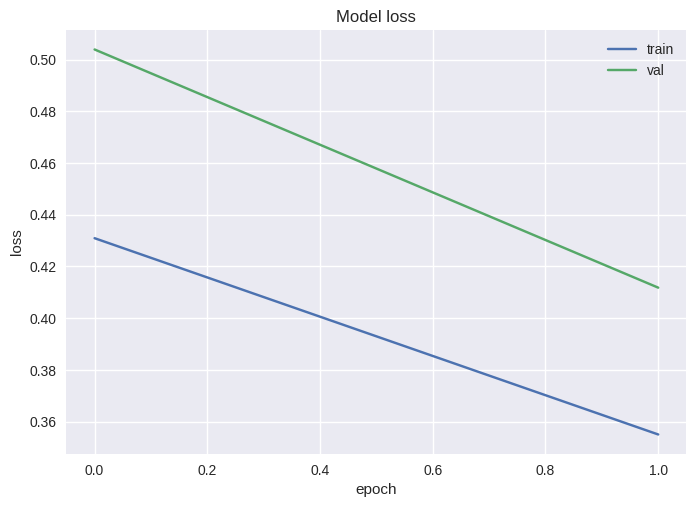

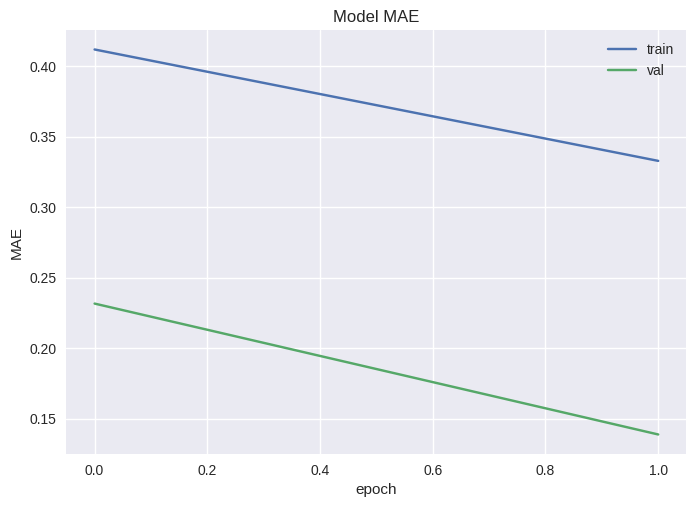

In [ ]:
visualization(history)

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae = unet_model.evaluate(test_dataset)
print("LOSS:", test_loss)
print("MAE:", test_mae)

87/87 [==============================] - 4s 46ms/step - loss: 0.4124 - mae: 0.1387
LOSS: 0.4124029874801636
MAE: 0.13869917392730713


In [ ]:
#unet_model = load_model('/content/drive/MyDrive/TFG_modelado/UNET + LSTM/Regresion/One-Step/Stateful/UNET_LSTM_Regression_One_Step_65_stateful_optimizado_2Epoch.h5')
unet_model = load_model('/content/drive/MyDrive/unet+lstm_regresion_one_step/UNET_LSTM_Regression_One_Step_65_stateful_optimizado_2Epoch_24hras.h5')

### Fase de prueba

#### **Predicción un valor sobre 2016 con stride = 1**

In [ ]:
sequence_length = 65
output_steps = 1
batch_size = 1
window_size = 65
n_sequences = 2500

In [ ]:
X_test_all, y_test_all = split_sequence(dataset_testing, performance_testing, sequence_length, output_steps, future_steps, stride = 1)

In [ ]:
print(X_test_all.shape)
print(y_test_all.shape)

(5639, 65, 16, 16, 3)
(5639,)


In [ ]:
test_dataset_all = tf.data.Dataset.from_tensor_slices((X_test_all, y_test_all))
test_dataset_all = test_dataset_all.batch(batch_size)

In [ ]:
print(f"Número de batches test = secuencias: {sum(1 for _ in test_dataset_all)}")

Número de batches test = secuencias: 5639


In [ ]:
predictions = prediccion_secuencias_multiples(unet_model, test_dataset_all, output_steps, window_size, n_sequences, 2)

In [ ]:
predictions.shape

(2501, 1)

In [ ]:
# Contar cuántas predicciones hay en cada rango
cantidad_0_1 = np.sum((predictions >= 0) & (predictions < 1))
cantidad_1_2 = np.sum((predictions >= 1) & (predictions < 2))
cantidad_2_3 = np.sum((predictions >= 2) & (predictions <= 3))
cantidad_3_4 = np.sum((predictions >= 3) & (predictions <= 4))
cantidad_4_5 = np.sum((predictions >= 4) & (predictions <= 5))

# Imprimir los resultados
print("Cantidad de predicciones entre 0 y 1:", cantidad_0_1)
print("Cantidad de predicciones entre 1 y 2:", cantidad_1_2)
print("Cantidad de predicciones entre 2 y 3:", cantidad_2_3)
print("Cantidad de predicciones entre 3 y 4:", cantidad_3_4)
print("Cantidad de predicciones entre 4 y 5:", cantidad_4_5)

Cantidad de predicciones entre 0 y 1: 1490
Cantidad de predicciones entre 1 y 2: 917
Cantidad de predicciones entre 2 y 3: 54
Cantidad de predicciones entre 3 y 4: 29
Cantidad de predicciones entre 4 y 5: 7


In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_secuencias_multiples_interactivo(prediction_seqs, window_size, dataset):
    # Calcular el promedio de las predicciones en cada punto de tiempo
    prediction_seqs = predictions.flatten()


    # Crear una lista para almacenar las trazas
    traces = []

    color_rojo_claro = 'hsl(0, 100%, 80%)'
    color_azul_claro = 'hsl(240, 100%, 80%)'

    # Graficar las predicciones promediadas
    x_values = list(range(sequence_length, len(dataset)))
    traces.append(go.Scatter(x=x_values, y=prediction_seqs, mode='lines', name='Predicciones promediadas', line=dict(color=color_azul_claro)))

    # Graficar los valores reales
    x_real_values = list(range(len(dataset)))
    traces.append(go.Scatter(x=x_real_values, y=dataset, mode='lines', name='Secuencia real', line=dict(color=color_rojo_claro)))

    # Crear el diseño del gráfico
    layout = go.Layout(
        title='Comparación de predicciones promediadas y secuencia real',
        xaxis=dict(title='Índice'),
        yaxis=dict(title='Valor'),
        showlegend=True
    )

    # Crear la figura
    fig = go.Figure(data=traces, layout=layout)

    # Mostrar el gráfico interactivo
    fig.show()

In [ ]:
performance_testing.shape

(5709,)

In [ ]:
plot_secuencias_multiples_interactivo(predictions, window_size, performance_testing)

## ⭐ (dropout, batchnormalization) 4 **EPOCH**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Flatten, Dense, Dropout, TimeDistributed, LSTM, BatchNormalization
from tensorflow.keras.models import Model

def build_model(input_layer=Input(batch_shape = (1, sequence_length, 16, 16, 3)), start_neurons=16):
    """Define la arquitectura U-Net"""

    drop_rate_hidden = 0.4

    # Convolution1
    conv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='EncodeConv1_1'))(input_layer)
    conv1 = TimeDistributed(Dropout(drop_rate_hidden))(conv1)
    conv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='EncodeConv1_2'))(conv1)
    pool1 = TimeDistributed(MaxPooling2D((2, 2), name='EncodeAveragePool1'))(conv1)

    # Convolution2
    conv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='BridgeConv_1'))(pool1)
    conv2 = TimeDistributed(Dropout(drop_rate_hidden))(conv2)
    conv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='BridgeConv_2'))(conv2)
    pool2 = TimeDistributed(MaxPooling2D((1, 2), name='EncodeAveragePool2'))(conv2)

    # Convolution3 (3er nivel)
    conv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='BridgeConv_3'))(pool2)
    conv3 = TimeDistributed(Dropout(drop_rate_hidden))(conv3)
    conv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='BridgeConv_4'))(conv3)
    pool3 = TimeDistributed(MaxPooling2D((2, 1), name='EncodeAveragePool3'))(conv3)

    # Convolution4 (4º nivel)
    conv4 = TimeDistributed(Conv2D(start_neurons * 32, (3, 3), activation='relu', padding="same", name='BridgeConv_5'))(pool3)
    conv4 = TimeDistributed(Dropout(drop_rate_hidden))(conv4)
    conv4 = TimeDistributed(Conv2D(start_neurons * 32, (3, 3), activation='relu', padding="same", name='BridgeConv_6'))(conv4)

    # Upsampling3
    deconv3 = TimeDistributed(Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 1), padding="same", name='DecodeUp3'))(conv4)
    uconv3 = concatenate([deconv3, conv3], axis=4, name='Concat3')
    uconv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='DecodeConv3_1'))(uconv3)
    uconv3 = TimeDistributed(Dropout(drop_rate_hidden))(uconv3)
    uconv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='DecodeConv3_2'))(uconv3)

    # Upsampling2
    deconv2 = TimeDistributed(Conv2DTranspose(start_neurons * 8, (3, 3), strides=(1, 2), padding="same", name='DecodeUp2'))(uconv3)
    uconv2 = concatenate([deconv2, conv2], axis=4, name='Concat2')
    uconv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='DecodeConv2_1'))(uconv2)
    uconv2 = TimeDistributed(Dropout(drop_rate_hidden))(uconv2)
    uconv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='DecodeConv2_2'))(uconv2)

    # Upsampling1
    deconv1 = TimeDistributed(Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same", name='DecodeUp1'))(uconv2)
    uconv1 = concatenate([deconv1, conv1], axis=4, name='Concat1')
    uconv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='DecodeConv1_1'))(uconv1)
    uconv1 = TimeDistributed(Dropout(drop_rate_hidden))(uconv1)
    uconv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='DecodeConv1_2'))(uconv1)

    # Flatten temporal
    flatten = TimeDistributed(Flatten(name='Flattening'))(uconv1)

    # Capas LSTM
    lstm1 = LSTM(32, return_sequences = True, recurrent_dropout = 0.25, stateful = True)(flatten)
    x = BatchNormalization()(lstm1)
    lstm2 = LSTM(32, return_sequences = True, recurrent_dropout = 0.25, stateful = True)(x)
    x = BatchNormalization()(lstm2)
    lstm2 = LSTM(64, stateful = True)(x)

    # Definir la salida de la red

    dense1 = Dense(64,activation='relu')(lstm2)
    dense1 = Dropout(drop_rate_hidden)(dense1)

    dense2 = Dense(32,activation='relu')(dense1)
    dense2 = Dropout(drop_rate_hidden)(dense2)

    output_layer = Dense(1, name='Classifier')(dense2)

    # Construir el modelo U-Net extendido
    unet = Model(input_layer, output_layer, name='UNET_LSTM_Regression_One_Step')

    return unet

# Ejemplo de uso
unet_model = build_model()
unet_model.summary()

Model: "UNET_LSTM_Regression_One_Step"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(1, 65, 16, 16, 3)]         0         []                            
                                                                                                  
 time_distributed (TimeDist  (1, 65, 16, 16, 64)          1792      ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (1, 65, 16, 16, 64)          0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                      

**Transfer Learning**

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/unet+lstm_regresion_one_step/unet_8x8_3D_Carlos.h5')

In [ ]:
# Obtener las capas hasta el aplanamiento en build_model
layers_to_transfer = []
for layer in new_model.layers:
    layers_to_transfer.append(layer)
    if layer.name == 'Flattening':
        break

In [ ]:
for layer in layers_to_transfer:
  print(layer.name)

input_1
EncodeConv1_1
dropout
EncodeConv1_2
EncodeAveragePool1
BridgeConv_1
dropout_1
BridgeConv_2
EncodeAveragePool2
BridgeConv_3
dropout_2
BridgeConv_4
EncodeAveragePool3
BridgeConv_5
dropout_3
BridgeConv_6
DecodeUp3
Concat3
DecodeConv3_1
dropout_4
DecodeConv3_2
DecodeUp2
Concat2
DecodeConv2_1
dropout_5
DecodeConv2_2
DecodeUp1
Concat1
DecodeConv1_1
dropout_6
DecodeConv1_2
Flattening


In [ ]:
# Obtener las capas correspondientes en build_model
unet_model_layers = unet_model.layers[:len(layers_to_transfer)]

In [ ]:
for layer in unet_model_layers:
  print(layer.name)

input_1
time_distributed
time_distributed_1
time_distributed_2
time_distributed_3
time_distributed_4
time_distributed_5
time_distributed_6
time_distributed_7
time_distributed_8
time_distributed_9
time_distributed_10
time_distributed_11
time_distributed_12
time_distributed_13
time_distributed_14
time_distributed_15
Concat3
time_distributed_16
time_distributed_17
time_distributed_18
time_distributed_19
Concat2
time_distributed_20
time_distributed_21
time_distributed_22
time_distributed_23
Concat1
time_distributed_24
time_distributed_25
time_distributed_26
time_distributed_27


In [ ]:
# Transfiere los pesos de new_model a unet_model y congela las capas
for layer1, layer2 in zip(layers_to_transfer, unet_model_layers):
    # Si la capa de unet_layers es TimeDistributed, transferimos los pesos internos
    if isinstance(layer2, tf.keras.layers.TimeDistributed):
        layer2_internal = layer2.layer
        layer2_internal.set_weights(layer1.get_weights())
    else:
        layer2.set_weights(layer1.get_weights())
    layer2.trainable = False

In [ ]:
unet_model.summary()

Model: "UNET_LSTM_Regression_One_Step"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(1, 65, 16, 16, 3)]         0         []                            
                                                                                                  
 time_distributed (TimeDist  (1, 65, 16, 16, 64)          1792      ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (1, 65, 16, 16, 64)          0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                      

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4)
unet_model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

In [ ]:
history = unet_model.fit(train_dataset,
  epochs=4,
  validation_data=test_dataset,
  callbacks=[early_stopping], verbose=1, shuffle = False)

Epoch 1/4
568/568 [==============================] - 152s 246ms/step - loss: 0.4541 - mae: 0.4172 - val_loss: 0.4163 - val_mae: 0.1635
Epoch 2/4
568/568 [==============================] - 137s 241ms/step - loss: 0.3479 - mae: 0.3234 - val_loss: 0.4357 - val_mae: 0.2882
Epoch 3/4
568/568 [==============================] - 135s 237ms/step - loss: 0.3134 - mae: 0.2905 - val_loss: 0.3813 - val_mae: 0.1474
Epoch 4/4
568/568 [==============================] - 135s 237ms/step - loss: 0.3096 - mae: 0.2684 - val_loss: 0.3927 - val_mae: 0.1532


In [ ]:
unet_model.save('/content/drive/MyDrive/unet+lstm_regresion_one_step/UNET_LSTM_Regression_One_Step_65_stateful_optimizado_4Epoch_24hras.h5')  # Guarda el modelo en tu Google Drive

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


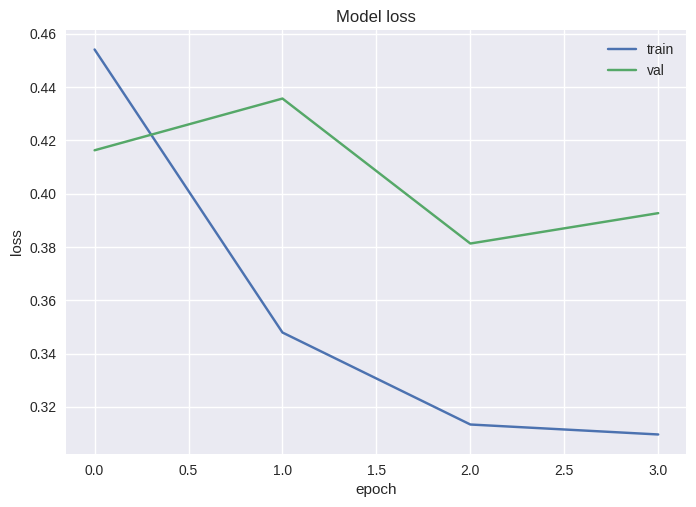

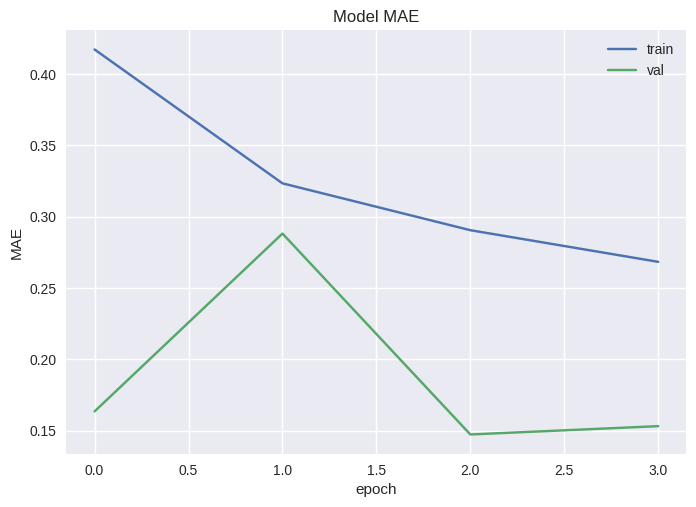

In [ ]:
visualization(history)

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae = unet_model.evaluate(test_dataset)
print("LOSS:", test_loss)
print("MAE:", test_mae)

87/87 [==============================] - 4s 44ms/step - loss: 0.3959 - mae: 0.1536
LOSS: 0.3958536386489868
MAE: 0.15359723567962646


In [ ]:
#unet_model = load_model('/content/drive/MyDrive/TFG_modelado/UNET + LSTM/Regresion/One-Step/Stateful/UNET_LSTM_Regression_One_Step_65_stateful_optimizado_2Epoch.h5')
unet_model = load_model('/content/drive/MyDrive/unet+lstm_regresion_one_step/UNET_LSTM_Regression_One_Step_65_stateful_optimizado_4Epoch_24hras.h5')

### Fase de prueba

#### **Predicción un valor sobre 2016 con stride = 1**

In [ ]:
sequence_length = 65
output_steps = 1
batch_size = 1
window_size = 65
n_sequences = 2500

In [ ]:
X_test_all, y_test_all = split_sequence(dataset_testing, performance_testing, sequence_length, output_steps, future_steps, stride = 1)

In [ ]:
print(X_test_all.shape)
print(y_test_all.shape)

(5639, 65, 16, 16, 3)
(5639,)


In [ ]:
test_dataset_all = tf.data.Dataset.from_tensor_slices((X_test_all, y_test_all))
test_dataset_all = test_dataset_all.batch(batch_size)

In [ ]:
print(f"Número de batches test = secuencias: {sum(1 for _ in test_dataset_all)}")

Número de batches test = secuencias: 5639


In [ ]:
predictions = prediccion_secuencias_multiples(unet_model, test_dataset_all, output_steps, window_size, n_sequences, 4)

In [ ]:
predictions.shape

(2501, 1)

In [ ]:
# Contar cuántas predicciones hay en cada rango
cantidad_0_1 = np.sum((predictions >= 0) & (predictions < 1))
cantidad_1_2 = np.sum((predictions >= 1) & (predictions < 2))
cantidad_2_3 = np.sum((predictions >= 2) & (predictions <= 3))
cantidad_3_4 = np.sum((predictions >= 3) & (predictions <= 4))
cantidad_4_5 = np.sum((predictions >= 4) & (predictions <= 5))

# Imprimir los resultados
print("Cantidad de predicciones entre 0 y 1:", cantidad_0_1)
print("Cantidad de predicciones entre 1 y 2:", cantidad_1_2)
print("Cantidad de predicciones entre 2 y 3:", cantidad_2_3)
print("Cantidad de predicciones entre 3 y 4:", cantidad_3_4)
print("Cantidad de predicciones entre 4 y 5:", cantidad_4_5)

Cantidad de predicciones entre 0 y 1: 1506
Cantidad de predicciones entre 1 y 2: 915
Cantidad de predicciones entre 2 y 3: 38
Cantidad de predicciones entre 3 y 4: 29
Cantidad de predicciones entre 4 y 5: 10


In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_secuencias_multiples_interactivo(prediction_seqs, window_size, dataset):
    # Calcular el promedio de las predicciones en cada punto de tiempo
    prediction_seqs = predictions.flatten()


    # Crear una lista para almacenar las trazas
    traces = []

    color_rojo_claro = 'hsl(0, 100%, 80%)'
    color_azul_claro = 'hsl(240, 100%, 80%)'

    # Graficar las predicciones promediadas
    x_values = list(range(sequence_length, len(dataset)))
    traces.append(go.Scatter(x=x_values, y=prediction_seqs, mode='lines', name='Predicciones promediadas', line=dict(color=color_azul_claro)))

    # Graficar los valores reales
    x_real_values = list(range(len(dataset)))
    traces.append(go.Scatter(x=x_real_values, y=dataset, mode='lines', name='Secuencia real', line=dict(color=color_rojo_claro)))

    # Crear el diseño del gráfico
    layout = go.Layout(
        title='Comparación de predicciones promediadas y secuencia real',
        xaxis=dict(title='Índice'),
        yaxis=dict(title='Valor'),
        showlegend=True
    )

    # Crear la figura
    fig = go.Figure(data=traces, layout=layout)

    # Mostrar el gráfico interactivo
    fig.show()

In [ ]:
performance_testing.shape

(5709,)

In [ ]:
plot_secuencias_multiples_interactivo(predictions, window_size, performance_testing)

## ⭐ (dropout, batchnormalization) 6 **EPOCH**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Flatten, Dense, Dropout, TimeDistributed, LSTM, BatchNormalization
from tensorflow.keras.models import Model

def build_model(input_layer=Input(batch_shape = (1, sequence_length, 16, 16, 3)), start_neurons=16):
    """Define la arquitectura U-Net"""

    drop_rate_hidden = 0.4

    # Convolution1
    conv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='EncodeConv1_1'))(input_layer)
    conv1 = TimeDistributed(Dropout(drop_rate_hidden))(conv1)
    conv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='EncodeConv1_2'))(conv1)
    pool1 = TimeDistributed(MaxPooling2D((2, 2), name='EncodeAveragePool1'))(conv1)

    # Convolution2
    conv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='BridgeConv_1'))(pool1)
    conv2 = TimeDistributed(Dropout(drop_rate_hidden))(conv2)
    conv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='BridgeConv_2'))(conv2)
    pool2 = TimeDistributed(MaxPooling2D((1, 2), name='EncodeAveragePool2'))(conv2)

    # Convolution3 (3er nivel)
    conv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='BridgeConv_3'))(pool2)
    conv3 = TimeDistributed(Dropout(drop_rate_hidden))(conv3)
    conv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='BridgeConv_4'))(conv3)
    pool3 = TimeDistributed(MaxPooling2D((2, 1), name='EncodeAveragePool3'))(conv3)

    # Convolution4 (4º nivel)
    conv4 = TimeDistributed(Conv2D(start_neurons * 32, (3, 3), activation='relu', padding="same", name='BridgeConv_5'))(pool3)
    conv4 = TimeDistributed(Dropout(drop_rate_hidden))(conv4)
    conv4 = TimeDistributed(Conv2D(start_neurons * 32, (3, 3), activation='relu', padding="same", name='BridgeConv_6'))(conv4)

    # Upsampling3
    deconv3 = TimeDistributed(Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 1), padding="same", name='DecodeUp3'))(conv4)
    uconv3 = concatenate([deconv3, conv3], axis=4, name='Concat3')
    uconv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='DecodeConv3_1'))(uconv3)
    uconv3 = TimeDistributed(Dropout(drop_rate_hidden))(uconv3)
    uconv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='DecodeConv3_2'))(uconv3)

    # Upsampling2
    deconv2 = TimeDistributed(Conv2DTranspose(start_neurons * 8, (3, 3), strides=(1, 2), padding="same", name='DecodeUp2'))(uconv3)
    uconv2 = concatenate([deconv2, conv2], axis=4, name='Concat2')
    uconv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='DecodeConv2_1'))(uconv2)
    uconv2 = TimeDistributed(Dropout(drop_rate_hidden))(uconv2)
    uconv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='DecodeConv2_2'))(uconv2)

    # Upsampling1
    deconv1 = TimeDistributed(Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same", name='DecodeUp1'))(uconv2)
    uconv1 = concatenate([deconv1, conv1], axis=4, name='Concat1')
    uconv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='DecodeConv1_1'))(uconv1)
    uconv1 = TimeDistributed(Dropout(drop_rate_hidden))(uconv1)
    uconv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='DecodeConv1_2'))(uconv1)

    # Flatten temporal
    flatten = TimeDistributed(Flatten(name='Flattening'))(uconv1)

    # Capas LSTM
    lstm1 = LSTM(32, return_sequences = True, recurrent_dropout = 0.25, stateful = True)(flatten)
    x = BatchNormalization()(lstm1)
    lstm2 = LSTM(32, return_sequences = True, recurrent_dropout = 0.25, stateful = True)(x)
    x = BatchNormalization()(lstm2)
    lstm2 = LSTM(64, stateful = True)(x)

    # Definir la salida de la red

    dense1 = Dense(64,activation='relu')(lstm2)
    dense1 = Dropout(drop_rate_hidden)(dense1)

    dense2 = Dense(32,activation='relu')(dense1)
    dense2 = Dropout(drop_rate_hidden)(dense2)

    output_layer = Dense(1, name='Classifier')(dense2)

    # Construir el modelo U-Net extendido
    unet = Model(input_layer, output_layer, name='UNET_LSTM_Regression_One_Step')

    return unet

# Ejemplo de uso
unet_model = build_model()
unet_model.summary()

Model: "UNET_LSTM_Regression_One_Step"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(1, 65, 16, 16, 3)]         0         []                            
                                                                                                  
 time_distributed (TimeDist  (1, 65, 16, 16, 64)          1792      ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (1, 65, 16, 16, 64)          0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                      

**Transfer Learning**

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/unet+lstm_regresion_one_step/unet_8x8_3D_Carlos.h5')

In [ ]:
# Obtener las capas hasta el aplanamiento en build_model
layers_to_transfer = []
for layer in new_model.layers:
    layers_to_transfer.append(layer)
    if layer.name == 'Flattening':
        break

In [ ]:
for layer in layers_to_transfer:
  print(layer.name)

input_1
EncodeConv1_1
dropout
EncodeConv1_2
EncodeAveragePool1
BridgeConv_1
dropout_1
BridgeConv_2
EncodeAveragePool2
BridgeConv_3
dropout_2
BridgeConv_4
EncodeAveragePool3
BridgeConv_5
dropout_3
BridgeConv_6
DecodeUp3
Concat3
DecodeConv3_1
dropout_4
DecodeConv3_2
DecodeUp2
Concat2
DecodeConv2_1
dropout_5
DecodeConv2_2
DecodeUp1
Concat1
DecodeConv1_1
dropout_6
DecodeConv1_2
Flattening


In [ ]:
# Obtener las capas correspondientes en build_model
unet_model_layers = unet_model.layers[:len(layers_to_transfer)]

In [ ]:
for layer in unet_model_layers:
  print(layer.name)

input_1
time_distributed
time_distributed_1
time_distributed_2
time_distributed_3
time_distributed_4
time_distributed_5
time_distributed_6
time_distributed_7
time_distributed_8
time_distributed_9
time_distributed_10
time_distributed_11
time_distributed_12
time_distributed_13
time_distributed_14
time_distributed_15
Concat3
time_distributed_16
time_distributed_17
time_distributed_18
time_distributed_19
Concat2
time_distributed_20
time_distributed_21
time_distributed_22
time_distributed_23
Concat1
time_distributed_24
time_distributed_25
time_distributed_26
time_distributed_27


In [ ]:
# Transfiere los pesos de new_model a unet_model y congela las capas
for layer1, layer2 in zip(layers_to_transfer, unet_model_layers):
    # Si la capa de unet_layers es TimeDistributed, transferimos los pesos internos
    if isinstance(layer2, tf.keras.layers.TimeDistributed):
        layer2_internal = layer2.layer
        layer2_internal.set_weights(layer1.get_weights())
    else:
        layer2.set_weights(layer1.get_weights())
    layer2.trainable = False

In [ ]:
unet_model.summary()

Model: "UNET_LSTM_Regression_One_Step"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(1, 65, 16, 16, 3)]         0         []                            
                                                                                                  
 time_distributed (TimeDist  (1, 65, 16, 16, 64)          1792      ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (1, 65, 16, 16, 64)          0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                      

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4)
unet_model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

In [ ]:
history = unet_model.fit(train_dataset,
  epochs=6,
  validation_data=test_dataset,
  callbacks=[early_stopping], verbose=1, shuffle = False)

Epoch 1/10
568/568 [==============================] - 141s 227ms/step - loss: 0.4977 - mae: 0.4674 - val_loss: 0.3599 - val_mae: 0.2251
Epoch 2/10
568/568 [==============================] - 130s 229ms/step - loss: 0.4309 - mae: 0.3955 - val_loss: 0.3442 - val_mae: 0.2207
Epoch 3/10
568/568 [==============================] - 129s 226ms/step - loss: 0.3576 - mae: 0.3380 - val_loss: 0.3885 - val_mae: 0.2658
Epoch 4/10
568/568 [==============================] - 129s 227ms/step - loss: 0.3508 - mae: 0.3134 - val_loss: 0.3875 - val_mae: 0.1822
Epoch 5/10
568/568 [==============================] - 130s 229ms/step - loss: 0.3198 - mae: 0.2810 - val_loss: 0.4489 - val_mae: 0.3601
Epoch 6/10
568/568 [==============================] - 130s 228ms/step - loss: 0.3022 - mae: 0.2617 - val_loss: 0.3654 - val_mae: 0.1596


In [ ]:
unet_model.save('/content/drive/MyDrive/unet+lstm_regresion_one_step/UNET_LSTM_Regression_One_Step_65_stateful_optimizado_6Epoch_24hras.h5')  # Guarda el modelo en tu Google Drive

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


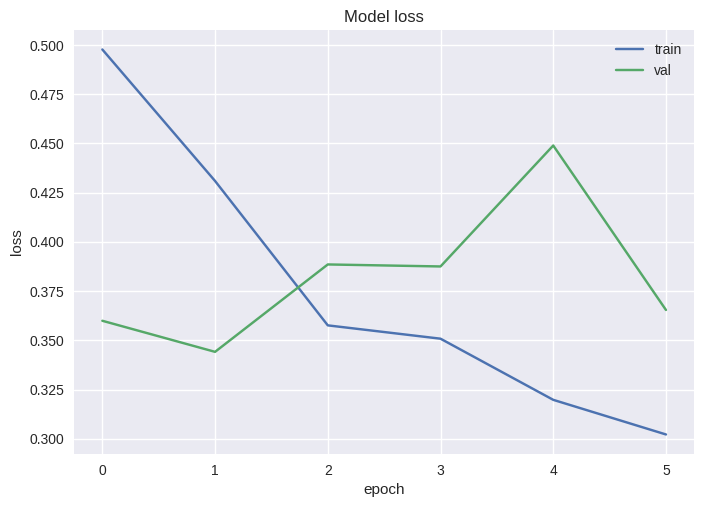

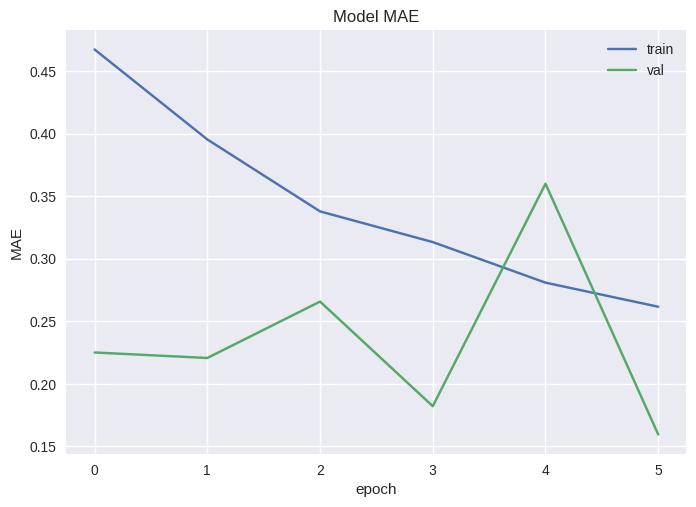

In [ ]:
visualization(history)

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae = unet_model.evaluate(test_dataset)
print("LOSS:", test_loss)
print("MAE:", test_mae)

87/87 [==============================] - 4s 42ms/step - loss: 0.3654 - mae: 0.1596
LOSS: 0.36542657017707825
MAE: 0.15956802666187286


In [ ]:
#unet_model = load_model('/content/drive/MyDrive/TFG_modelado/UNET + LSTM/Regresion/One-Step/Stateful/UNET_LSTM_Regression_One_Step_65_stateful_optimizado_2Epoch.h5')
unet_model = load_model('/content/drive/MyDrive/unet+lstm_regresion_one_step/UNET_LSTM_Regression_One_Step_65_stateful_optimizado_6Epoch_24hras.h5')

### Fase de prueba

#### **Predicción un valor sobre 2016 con stride = 1**

In [ ]:
sequence_length = 65
output_steps = 1
batch_size = 1
window_size = 65
n_sequences = 2500

In [ ]:
X_test_all, y_test_all = split_sequence(dataset_testing, performance_testing, sequence_length, output_steps, future_steps, stride = 1)

In [ ]:
print(X_test_all.shape)
print(y_test_all.shape)

(5639, 65, 16, 16, 3)
(5639,)


In [ ]:
test_dataset_all = tf.data.Dataset.from_tensor_slices((X_test_all, y_test_all))
test_dataset_all = test_dataset_all.batch(batch_size)

In [ ]:
print(f"Número de batches test = secuencias: {sum(1 for _ in test_dataset_all)}")

Número de batches test = secuencias: 5639


In [ ]:
predictions = prediccion_secuencias_multiples(unet_model, test_dataset_all, output_steps, window_size, n_sequences, 4)

In [ ]:
predictions.shape

(2501, 1)

In [ ]:
# Contar cuántas predicciones hay en cada rango
cantidad_0_1 = np.sum((predictions >= 0) & (predictions < 1))
cantidad_1_2 = np.sum((predictions >= 1) & (predictions < 2))
cantidad_2_3 = np.sum((predictions >= 2) & (predictions <= 3))
cantidad_3_4 = np.sum((predictions >= 3) & (predictions <= 4))
cantidad_4_5 = np.sum((predictions >= 4) & (predictions <= 5))

# Imprimir los resultados
print("Cantidad de predicciones entre 0 y 1:", cantidad_0_1)
print("Cantidad de predicciones entre 1 y 2:", cantidad_1_2)
print("Cantidad de predicciones entre 2 y 3:", cantidad_2_3)
print("Cantidad de predicciones entre 3 y 4:", cantidad_3_4)
print("Cantidad de predicciones entre 4 y 5:", cantidad_4_5)

Cantidad de predicciones entre 0 y 1: 1353
Cantidad de predicciones entre 1 y 2: 1073
Cantidad de predicciones entre 2 y 3: 35
Cantidad de predicciones entre 3 y 4: 25
Cantidad de predicciones entre 4 y 5: 14


In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_secuencias_multiples_interactivo(prediction_seqs, window_size, dataset):
    # Calcular el promedio de las predicciones en cada punto de tiempo
    prediction_seqs = predictions.flatten()


    # Crear una lista para almacenar las trazas
    traces = []

    color_rojo_claro = 'hsl(0, 100%, 80%)'
    color_azul_claro = 'hsl(240, 100%, 80%)'

    # Graficar las predicciones promediadas
    x_values = list(range(sequence_length, len(dataset)))
    traces.append(go.Scatter(x=x_values, y=prediction_seqs, mode='lines', name='Predicciones promediadas', line=dict(color=color_azul_claro)))

    # Graficar los valores reales
    x_real_values = list(range(len(dataset)))
    traces.append(go.Scatter(x=x_real_values, y=dataset, mode='lines', name='Secuencia real', line=dict(color=color_rojo_claro)))

    # Crear el diseño del gráfico
    layout = go.Layout(
        title='Comparación de predicciones promediadas y secuencia real',
        xaxis=dict(title='Índice'),
        yaxis=dict(title='Valor'),
        showlegend=True
    )

    # Crear la figura
    fig = go.Figure(data=traces, layout=layout)

    # Mostrar el gráfico interactivo
    fig.show()

In [ ]:
performance_testing.shape

(5709,)

In [ ]:
plot_secuencias_multiples_interactivo(predictions, window_size, performance_testing)

## ⭐ (dropout, batchnormalization) 10 **EPOCH**

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Flatten, Dense, Dropout, TimeDistributed, LSTM, BatchNormalization
from tensorflow.keras.models import Model

def build_model(input_layer=Input(batch_shape = (1, sequence_length, 16, 16, 3)), start_neurons=16):
    """Define la arquitectura U-Net"""

    drop_rate_hidden = 0.4

    # Convolution1
    conv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='EncodeConv1_1'))(input_layer)
    conv1 = TimeDistributed(Dropout(drop_rate_hidden))(conv1)
    conv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='EncodeConv1_2'))(conv1)
    pool1 = TimeDistributed(MaxPooling2D((2, 2), name='EncodeAveragePool1'))(conv1)

    # Convolution2
    conv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='BridgeConv_1'))(pool1)
    conv2 = TimeDistributed(Dropout(drop_rate_hidden))(conv2)
    conv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='BridgeConv_2'))(conv2)
    pool2 = TimeDistributed(MaxPooling2D((1, 2), name='EncodeAveragePool2'))(conv2)

    # Convolution3 (3er nivel)
    conv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='BridgeConv_3'))(pool2)
    conv3 = TimeDistributed(Dropout(drop_rate_hidden))(conv3)
    conv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='BridgeConv_4'))(conv3)
    pool3 = TimeDistributed(MaxPooling2D((2, 1), name='EncodeAveragePool3'))(conv3)

    # Convolution4 (4º nivel)
    conv4 = TimeDistributed(Conv2D(start_neurons * 32, (3, 3), activation='relu', padding="same", name='BridgeConv_5'))(pool3)
    conv4 = TimeDistributed(Dropout(drop_rate_hidden))(conv4)
    conv4 = TimeDistributed(Conv2D(start_neurons * 32, (3, 3), activation='relu', padding="same", name='BridgeConv_6'))(conv4)

    # Upsampling3
    deconv3 = TimeDistributed(Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 1), padding="same", name='DecodeUp3'))(conv4)
    uconv3 = concatenate([deconv3, conv3], axis=4, name='Concat3')
    uconv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='DecodeConv3_1'))(uconv3)
    uconv3 = TimeDistributed(Dropout(drop_rate_hidden))(uconv3)
    uconv3 = TimeDistributed(Conv2D(start_neurons * 16, (3, 3), activation='relu', padding="same", name='DecodeConv3_2'))(uconv3)

    # Upsampling2
    deconv2 = TimeDistributed(Conv2DTranspose(start_neurons * 8, (3, 3), strides=(1, 2), padding="same", name='DecodeUp2'))(uconv3)
    uconv2 = concatenate([deconv2, conv2], axis=4, name='Concat2')
    uconv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='DecodeConv2_1'))(uconv2)
    uconv2 = TimeDistributed(Dropout(drop_rate_hidden))(uconv2)
    uconv2 = TimeDistributed(Conv2D(start_neurons * 8, (3, 3), activation='relu', padding="same", name='DecodeConv2_2'))(uconv2)

    # Upsampling1
    deconv1 = TimeDistributed(Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same", name='DecodeUp1'))(uconv2)
    uconv1 = concatenate([deconv1, conv1], axis=4, name='Concat1')
    uconv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='DecodeConv1_1'))(uconv1)
    uconv1 = TimeDistributed(Dropout(drop_rate_hidden))(uconv1)
    uconv1 = TimeDistributed(Conv2D(start_neurons * 4, (3, 3), activation='relu', padding="same", name='DecodeConv1_2'))(uconv1)

    # Flatten temporal
    flatten = TimeDistributed(Flatten(name='Flattening'))(uconv1)

    # Capas LSTM
    lstm1 = LSTM(32, return_sequences = True, recurrent_dropout = 0.25, stateful = True)(flatten)
    x = BatchNormalization()(lstm1)
    lstm2 = LSTM(32, return_sequences = True, recurrent_dropout = 0.25, stateful = True)(x)
    x = BatchNormalization()(lstm2)
    lstm2 = LSTM(64, stateful = True)(x)

    # Definir la salida de la red

    dense1 = Dense(64,activation='relu')(lstm2)
    dense1 = Dropout(drop_rate_hidden)(dense1)

    dense2 = Dense(32,activation='relu')(dense1)
    dense2 = Dropout(drop_rate_hidden)(dense2)

    output_layer = Dense(1, name='Classifier')(dense2)

    # Construir el modelo U-Net extendido
    unet = Model(input_layer, output_layer, name='UNET_LSTM_Regression_One_Step')

    return unet

# Ejemplo de uso
unet_model = build_model()
unet_model.summary()

Model: "UNET_LSTM_Regression_One_Step"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(1, 65, 16, 16, 3)]         0         []                            
                                                                                                  
 time_distributed (TimeDist  (1, 65, 16, 16, 64)          1792      ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (1, 65, 16, 16, 64)          0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                      

**Transfer Learning**

In [39]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/unet+lstm_regresion_one_step/unet_8x8_3D_Carlos.h5')

In [40]:
# Obtener las capas hasta el aplanamiento en build_model
layers_to_transfer = []
for layer in new_model.layers:
    layers_to_transfer.append(layer)
    if layer.name == 'Flattening':
        break

In [41]:
for layer in layers_to_transfer:
  print(layer.name)

input_1
EncodeConv1_1
dropout
EncodeConv1_2
EncodeAveragePool1
BridgeConv_1
dropout_1
BridgeConv_2
EncodeAveragePool2
BridgeConv_3
dropout_2
BridgeConv_4
EncodeAveragePool3
BridgeConv_5
dropout_3
BridgeConv_6
DecodeUp3
Concat3
DecodeConv3_1
dropout_4
DecodeConv3_2
DecodeUp2
Concat2
DecodeConv2_1
dropout_5
DecodeConv2_2
DecodeUp1
Concat1
DecodeConv1_1
dropout_6
DecodeConv1_2
Flattening


In [42]:
# Obtener las capas correspondientes en build_model
unet_model_layers = unet_model.layers[:len(layers_to_transfer)]

In [43]:
for layer in unet_model_layers:
  print(layer.name)

input_1
time_distributed
time_distributed_1
time_distributed_2
time_distributed_3
time_distributed_4
time_distributed_5
time_distributed_6
time_distributed_7
time_distributed_8
time_distributed_9
time_distributed_10
time_distributed_11
time_distributed_12
time_distributed_13
time_distributed_14
time_distributed_15
Concat3
time_distributed_16
time_distributed_17
time_distributed_18
time_distributed_19
Concat2
time_distributed_20
time_distributed_21
time_distributed_22
time_distributed_23
Concat1
time_distributed_24
time_distributed_25
time_distributed_26
time_distributed_27


In [44]:
# Transfiere los pesos de new_model a unet_model y congela las capas
for layer1, layer2 in zip(layers_to_transfer, unet_model_layers):
    # Si la capa de unet_layers es TimeDistributed, transferimos los pesos internos
    if isinstance(layer2, tf.keras.layers.TimeDistributed):
        layer2_internal = layer2.layer
        layer2_internal.set_weights(layer1.get_weights())
    else:
        layer2.set_weights(layer1.get_weights())
    layer2.trainable = False

In [45]:
unet_model.summary()

Model: "UNET_LSTM_Regression_One_Step"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(1, 65, 16, 16, 3)]         0         []                            
                                                                                                  
 time_distributed (TimeDist  (1, 65, 16, 16, 64)          1792      ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (1, 65, 16, 16, 64)          0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                      

In [46]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4)
unet_model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

In [47]:
history = unet_model.fit(train_dataset,
  epochs=10,
  validation_data=test_dataset, verbose=1, shuffle = False)

Epoch 1/10
568/568 [==============================] - 150s 243ms/step - loss: 0.5013 - mae: 0.4794 - val_loss: 0.3719 - val_mae: 0.2064
Epoch 2/10
568/568 [==============================] - 140s 247ms/step - loss: 0.3917 - mae: 0.3764 - val_loss: 0.4225 - val_mae: 0.1959
Epoch 3/10
568/568 [==============================] - 139s 245ms/step - loss: 0.3437 - mae: 0.3354 - val_loss: 0.4196 - val_mae: 0.2682
Epoch 4/10
568/568 [==============================] - 137s 242ms/step - loss: 0.3303 - mae: 0.2985 - val_loss: 0.3607 - val_mae: 0.2025
Epoch 5/10
568/568 [==============================] - 136s 240ms/step - loss: 0.2994 - mae: 0.2787 - val_loss: 0.3522 - val_mae: 0.1609
Epoch 6/10
568/568 [==============================] - 135s 238ms/step - loss: 0.2929 - mae: 0.2510 - val_loss: 0.4066 - val_mae: 0.1782
Epoch 7/10
568/568 [==============================] - 137s 241ms/step - loss: 0.2934 - mae: 0.2352 - val_loss: 0.3985 - val_mae: 0.1476
Epoch 8/10
568/568 [============================

In [48]:
unet_model.save('/content/drive/MyDrive/unet+lstm_regresion_one_step/UNET_LSTM_Regression_One_Step_65_stateful_optimizado_10Epoch_24hras.h5')  # Guarda el modelo en tu Google Drive

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


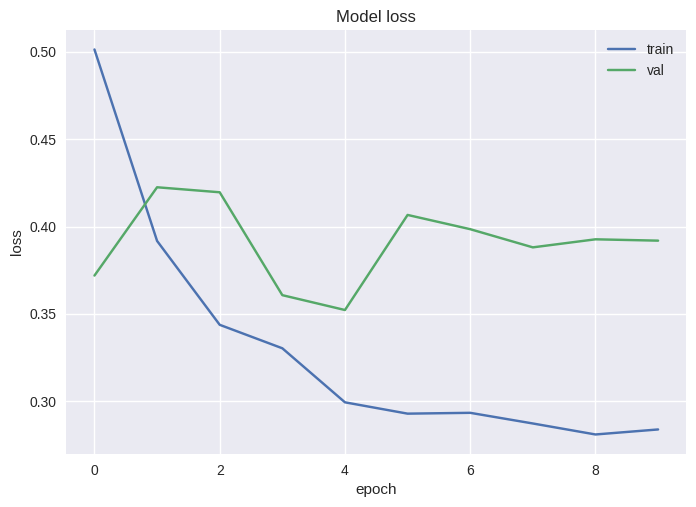

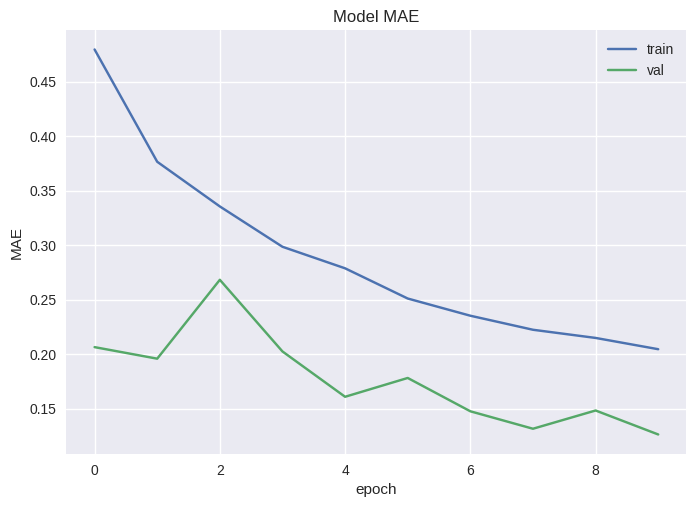

In [49]:
visualization(history)

In [50]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae = unet_model.evaluate(test_dataset)
print("LOSS:", test_loss)
print("MAE:", test_mae)

87/87 [==============================] - 5s 55ms/step - loss: 0.3919 - mae: 0.1264
LOSS: 0.3919094204902649
MAE: 0.1263568103313446


In [51]:
#unet_model = load_model('/content/drive/MyDrive/TFG_modelado/UNET + LSTM/Regresion/One-Step/Stateful/UNET_LSTM_Regression_One_Step_65_stateful_optimizado_2Epoch.h5')
unet_model = load_model('/content/drive/MyDrive/unet+lstm_regresion_one_step/UNET_LSTM_Regression_One_Step_65_stateful_optimizado_10Epoch_24hras.h5')

### Fase de prueba

#### **Predicción un valor sobre 2016 con stride = 1**

In [52]:
sequence_length = 65
output_steps = 1
batch_size = 1
window_size = 65
n_sequences = 2500

In [53]:
X_test_all, y_test_all = split_sequence(dataset_testing, performance_testing, sequence_length, output_steps, future_steps, stride = 1)

In [54]:
print(X_test_all.shape)
print(y_test_all.shape)

(5639, 65, 16, 16, 3)
(5639,)


In [55]:
test_dataset_all = tf.data.Dataset.from_tensor_slices((X_test_all, y_test_all))
test_dataset_all = test_dataset_all.batch(batch_size)

In [56]:
print(f"Número de batches test = secuencias: {sum(1 for _ in test_dataset_all)}")

Número de batches test = secuencias: 5639


In [57]:
predictions = prediccion_secuencias_multiples(unet_model, test_dataset_all, output_steps, window_size, n_sequences, 4)

In [58]:
predictions.shape

(2501, 1)

In [59]:
# Contar cuántas predicciones hay en cada rango
cantidad_0_1 = np.sum((predictions >= 0) & (predictions < 1))
cantidad_1_2 = np.sum((predictions >= 1) & (predictions < 2))
cantidad_2_3 = np.sum((predictions >= 2) & (predictions <= 3))
cantidad_3_4 = np.sum((predictions >= 3) & (predictions <= 4))
cantidad_4_5 = np.sum((predictions >= 4) & (predictions <= 5))

# Imprimir los resultados
print("Cantidad de predicciones entre 0 y 1:", cantidad_0_1)
print("Cantidad de predicciones entre 1 y 2:", cantidad_1_2)
print("Cantidad de predicciones entre 2 y 3:", cantidad_2_3)
print("Cantidad de predicciones entre 3 y 4:", cantidad_3_4)
print("Cantidad de predicciones entre 4 y 5:", cantidad_4_5)

Cantidad de predicciones entre 0 y 1: 1314
Cantidad de predicciones entre 1 y 2: 1150
Cantidad de predicciones entre 2 y 3: 33
Cantidad de predicciones entre 3 y 4: 4
Cantidad de predicciones entre 4 y 5: 0


In [60]:
import numpy as np
import plotly.graph_objects as go

def plot_secuencias_multiples_interactivo(prediction_seqs, window_size, dataset):
    # Calcular el promedio de las predicciones en cada punto de tiempo
    prediction_seqs = predictions.flatten()


    # Crear una lista para almacenar las trazas
    traces = []

    color_rojo_claro = 'hsl(0, 100%, 80%)'
    color_azul_claro = 'hsl(240, 100%, 80%)'

    # Graficar las predicciones promediadas
    x_values = list(range(sequence_length, len(dataset)))
    traces.append(go.Scatter(x=x_values, y=prediction_seqs, mode='lines', name='Predicciones promediadas', line=dict(color=color_azul_claro)))

    # Graficar los valores reales
    x_real_values = list(range(len(dataset)))
    traces.append(go.Scatter(x=x_real_values, y=dataset, mode='lines', name='Secuencia real', line=dict(color=color_rojo_claro)))

    # Crear el diseño del gráfico
    layout = go.Layout(
        title='Comparación de predicciones promediadas y secuencia real',
        xaxis=dict(title='Índice'),
        yaxis=dict(title='Valor'),
        showlegend=True
    )

    # Crear la figura
    fig = go.Figure(data=traces, layout=layout)

    # Mostrar el gráfico interactivo
    fig.show()

In [61]:
performance_testing.shape

(5709,)

In [62]:
plot_secuencias_multiples_interactivo(predictions, window_size, performance_testing)

## Comprobacion etiquetas imagenes por año

In [ ]:
import pandas as pd
import plotly.graph_objects as go

def plot_secuencias_por_año(df):
    # Obtener una lista de años únicos presentes en la columna 'Fecha_Inicio'
    años = df['Fecha_Inicio'].dt.year.unique()

    color_rojo_claro = 'hsl(0, 100%, 80%)'

    # Iterar sobre cada año
    for año in años:
        # Crear una figura para cada año
        fig = go.Figure()

        # Filtrar el DataFrame para incluir solo las filas correspondientes a este año
        df_año = df[df['Fecha_Inicio'].dt.year == año]

        # Obtener la secuencia completa de etiquetas para este año
        etiquetas_año = df_año['label'].tolist()  # Reemplaza 'tu_columna_de_etiquetas' con el nombre de la columna de etiquetas en tu DataFrame

        # Agregar la secuencia de etiquetas al gráfico
        fig.add_trace(go.Scatter(x=list(range(len(etiquetas_año))), y=etiquetas_año,
                                  mode='lines', name=f'Etiquetas {año}', line=dict(color=color_rojo_claro)))

        # Establecer el diseño del gráfico
        fig.update_layout(
            title=f'Secuencia completa de etiquetas para el año {año}',
            xaxis_title='Índice',
            yaxis_title='Valor'
        )

        # Mostrar el gráfico interactivo
        fig.show()

In [ ]:
plot_secuencias_por_año(df_wt2_completo_copy)